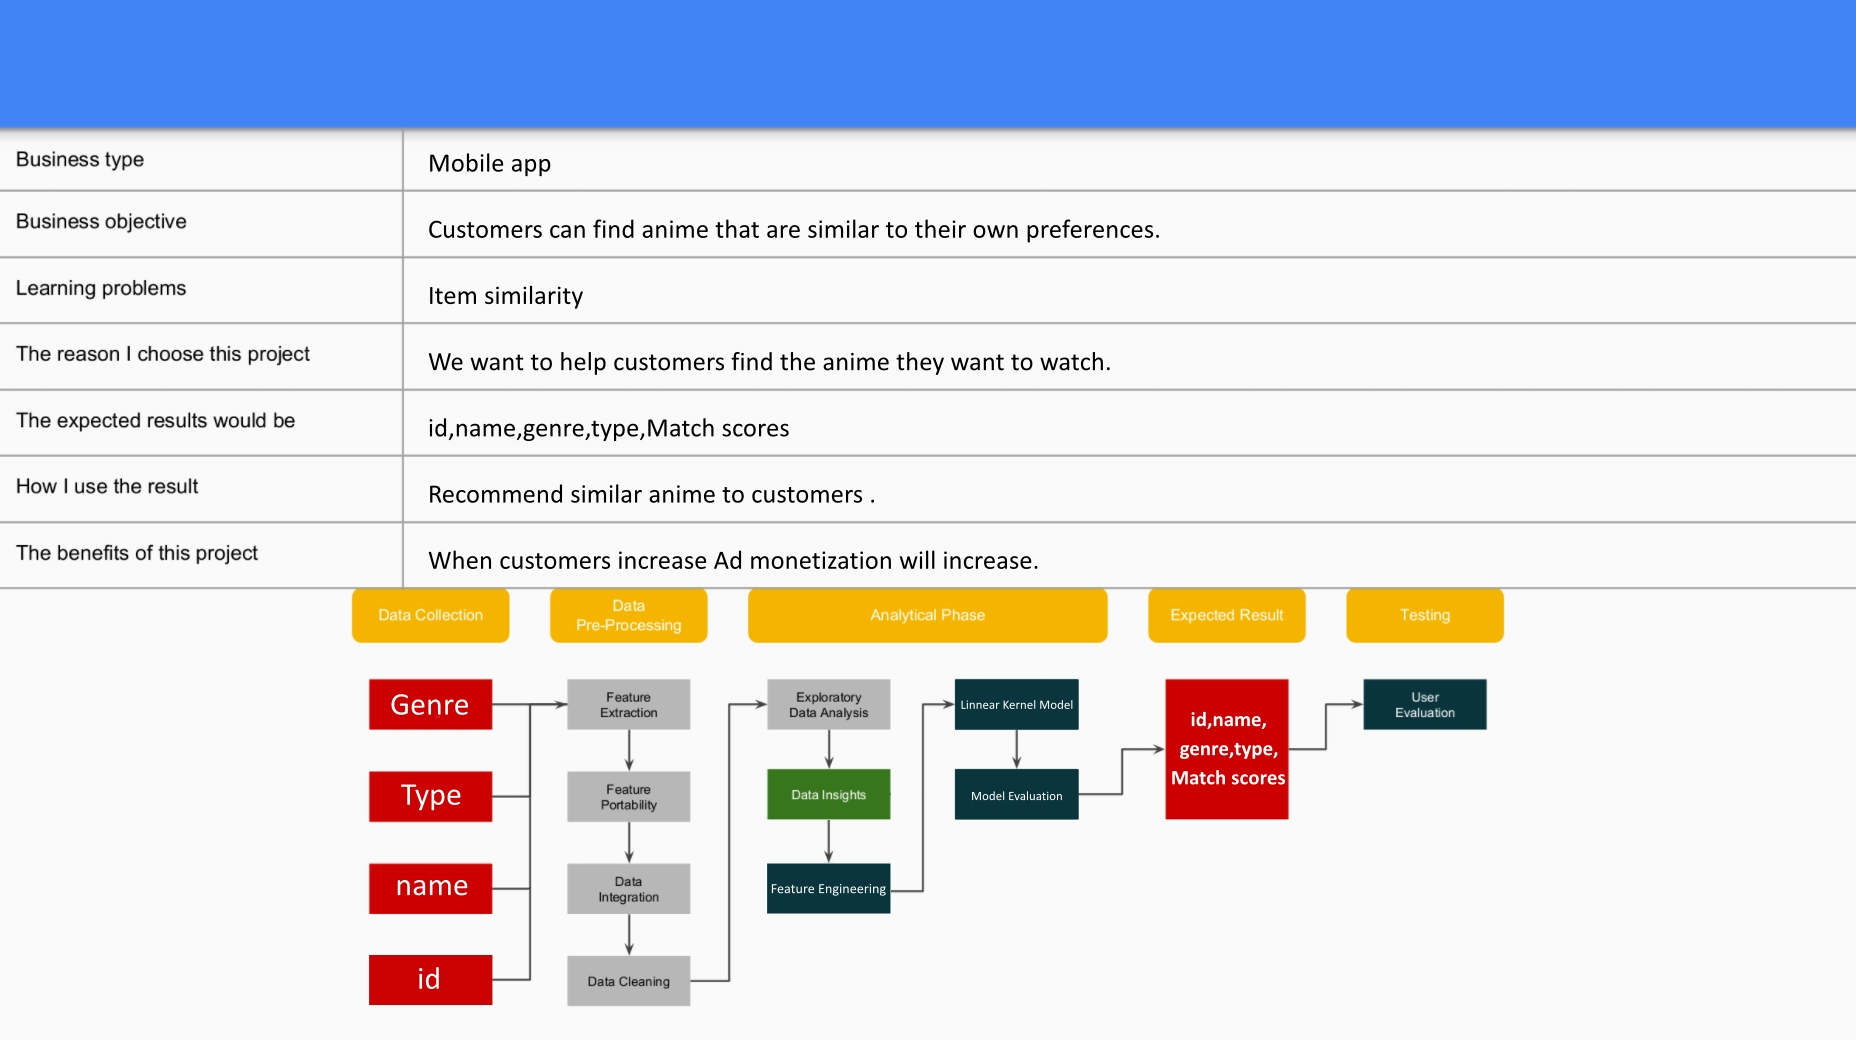

# Import libs

In [ ]:
#import data
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import re
import string

#model rank
#it calculates the frequency of the word with the consideration on how often it occurs in all documents.  มีซ้ำยิ่งเยอะ น้ำหนักยิ่งมาก
from sklearn.feature_extraction.text import TfidfVectorizer
#เลือกจากธรรมชาตของag
#เลือกtfเพราะ agเป้นการเเบ่งคำเเล้วเอาคำนั้นไปweightทุกๆdocumentที่มีอยุ่ ในขนาดที่cv countคำของrecodนั้นๆ
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
import time

# Import data

In [ ]:
#เก็บข้อมูลลงในในตัวเเปลanime
anime = pd.read_csv('https://raw.githubusercontent.com/nestor94/animender/master/data/anime.csv')
anime.tail(5)

,anime_id,name,genre,type,episodes,rating,members
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175
12293,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142


# Check

In [ ]:
#check info
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [ ]:
#checkมีซ้ำป่าว
anime.duplicated().sum()

0

In [ ]:
#check ค่าnullที่อยู่ในdataframe
anime.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [ ]:
#check ว่าค่าnullมีทั้งหมด%ในdataframe
(anime.isna().sum()/anime.shape[0]).round(2)

anime_id    0.00
name        0.00
genre       0.01
type        0.00
episodes    0.00
rating      0.02
members     0.00
dtype: float64

# Data-Prepocessing

ที่ไม่ได้เอาตัวเเปลanimeไปทำPre-processingเพราะจะเก็บไว้ในการrun pipeline

In [ ]:
#ทำตัวเเปลใหม่ที่ชื่อว่า df ในนั้นได้เก็บข้อมูลที่มาจากanime
df = anime.copy()

In [ ]:
#drop row ที่มีค่าnull
df.dropna(axis=0 ,inplace=True)
df.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [ ]:
#check dataframe ของdf
df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [ ]:
#reset index ที่ไม่ถูกต้องของdataframe df
df.reset_index(drop=True,inplace=True)
df.tail()

,anime_id,name,genre,type,episodes,rating,members
12012,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12013,5543,Under World,Hentai,OVA,1,4.28,183
12014,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12015,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175
12016,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142


In [ ]:
#เปลี่ยนgenreให้ใช้กับmodelได้
mapping = {'Sci-Fi':'SciFi','Slice of Life':'SliceOfLife','Martial Arts':'MartialArts','Super Power':'SuperPower','Shounen Ai':'ShounenAi','Shoujo Ai':'ShoujoAi'}
ndf = df.copy()#สร้างตัวเเปลใหม่ที่ชื่อว่าndf ได้เก็บข้อมูลของ dataframe df
ndf['genre'] = df['genre'].replace(mapping,regex=True) #เปลี่ยนgenreของทีละเรื่องให้ใช้กับmodelได้
ndf#check dataframe ndf

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"SciFi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12012,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12013,5543,Under World,Hentai,OVA,1,4.28,183
12014,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12015,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


function ที่ไม่ได้ใช้

In [ ]:
#จะทำงานเเบบเปลี่ยนให้ ชื่อเรื่องตรงไหนที่มีอักษรไม่ปกติ ให้เป็นปกติ
'''def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'Â°', '',text)
    
    return text

anime['name'] = anime['name'].apply(text_cleaning)
anime'''

'def text_cleaning(text):\n    text = re.sub(r\'&quot;\', \'\', text)\n    text  = "".join([char for char in text if char not in string.punctuation])\n    text = re.sub(r\'.hack//\', \'\', text)\n    text = re.sub(r\'&#039;\', \'\', text)\n    text = re.sub(r\'A&#039;s\', \'\', text)\n    text = re.sub(r\'I&#039;\', \'I\'\', text)\n    text = re.sub(r\'&amp;\', \'and\', text)\n    text = re.sub(r\'Â°\', \'\',text)\n    \n    return text\n\nanime[\'name\'] = anime[\'name\'].apply(text_cleaning)\nanime'

code ที่ไม่ได้ใช้

In [ ]:
#จะทำให่้เอาไปคำนวณmartixได้ เป็นเเบบ dataframe concat
#anime_features = pd.concat([anime["genre"].str.get_dummies(sep=", "),pd.get_dummies(anime[["type"]]),anime[["rating"]],anime[["members"]]],axis=1)
#anime_features

#EDA

In [ ]:
#เเบ่งgenreออกมาเเล้วนับว่าเเต่ละgenreมีทั้งหมดกี่ตัว
def countgenre(data):
  dicts = {}
  for x in data:
    for y in x:
      if y not in dicts.keys():
        dicts[y] = 0
      dicts[y] = int(dicts[y])+1
  return dicts

In [ ]:
GENRE = 'genre'
GENRE = df[GENRE].str.split(", ") #เเบ่งด้วยsplit
GENRE = countgenre(GENRE)#เข้าไปในfunctionเเล้วreturnที่เเบ่งเเล้วออกมา
GENRE

{'Action': 2768,
 'Adventure': 2316,
 'Cars': 72,
 'Comedy': 4575,
 'Dementia': 238,
 'Demons': 287,
 'Drama': 1977,
 'Ecchi': 628,
 'Fantasy': 2242,
 'Game': 177,
 'Harem': 313,
 'Hentai': 1133,
 'Historical': 798,
 'Horror': 362,
 'Josei': 52,
 'Kids': 1598,
 'Magic': 747,
 'Martial Arts': 264,
 'Mecha': 929,
 'Military': 416,
 'Music': 842,
 'Mystery': 485,
 'Parody': 403,
 'Police': 195,
 'Psychological': 226,
 'Romance': 1437,
 'Samurai': 146,
 'School': 1176,
 'Sci-Fi': 2036,
 'Seinen': 532,
 'Shoujo': 594,
 'Shoujo Ai': 54,
 'Shounen': 1684,
 'Shounen Ai': 62,
 'Slice of Life': 1204,
 'Space': 377,
 'Sports': 533,
 'Super Power': 451,
 'Supernatural': 1001,
 'Thriller': 86,
 'Vampire': 100,
 'Yaoi': 38,
 'Yuri': 41}

In [ ]:
#เอา genre เเละ จำนวนของgenre มารวมกันเป็นdataframeเพื่อทำกราฟ
colGenre = pd.DataFrame(data=GENRE.keys(),columns=['genre'])
rowGenre = pd.DataFrame(data=GENRE.values(),columns=['count_genre'])
colGenre.reset_index(inplace=True)
rowGenre.reset_index(inplace=True)
Genre = pd.merge(colGenre,rowGenre,on=['index','index'])
Genre

,index,genre,count_genre
0,0,Drama,1977
1,1,Romance,1437
2,2,School,1176
3,3,Supernatural,1001
4,4,Action,2768
5,5,Adventure,2316
6,6,Fantasy,2242
7,7,Magic,747
8,8,Military,416
9,9,Shounen,1684


In [ ]:
alt.Chart(Genre, title='Anime Genre').mark_bar().encode(
    x='count_genre:Q',
    y=alt.Y('genre:O', sort='-x'),
    tooltip=list(Genre.columns)
).properties(width=900,height=600)


alt.Chart(...)

* ประเภท comedy มากที่สุด 4575 เรื่อง
* รองลงมาคือ action 2768 เรื่อง
* ต่ำที่สุดคือประเภท yaoi 38 เรื่อง

Text(0, 0.5, 'Community Size')

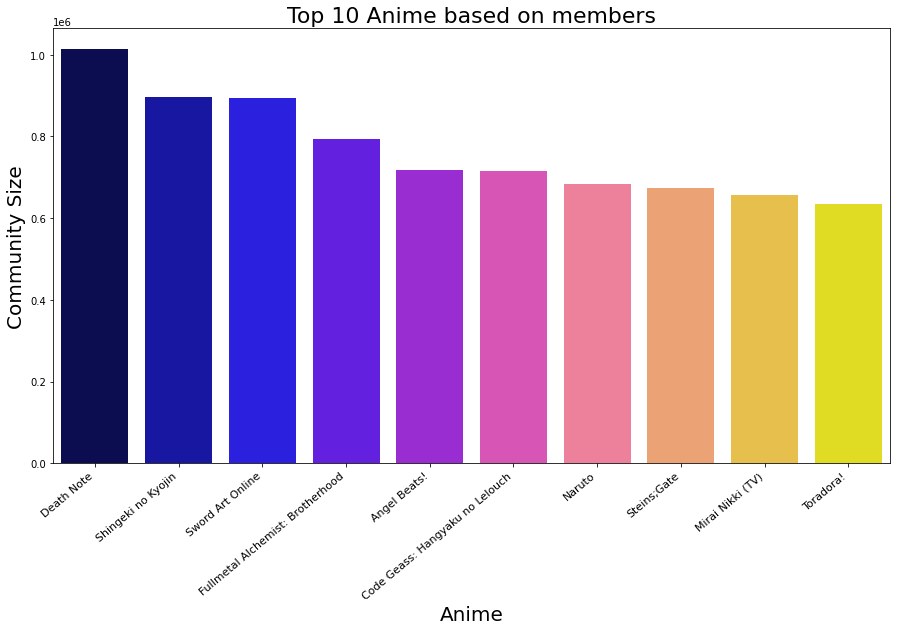

In [ ]:
top10=df[['name', 'members']].sort_values(by = 'members',ascending = False).head(10)
plt.figure(figsize=(15,8))
ax=sns.barplot(x="name", y="members", data=top10, palette="gnuplot2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on members',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('Community Size', fontsize = 20)

* 10 อันดับที่เมมเบอร์โหวตมากที่สุด (Community Size หน่วยเป็นล้าน)
* death note community size มากที่สุด ซึ่งอยู่ในประเภท Mystery, Police,  Psychological, Supernatural
* รองลงมาคือ shingeki no kyojin และ Sword Art Online    
* จะเห็นว่า type จะเป็น TV ทั้งหมด

In [ ]:
df.sort_values(by = 'members',ascending = False).head(10)

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
445,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


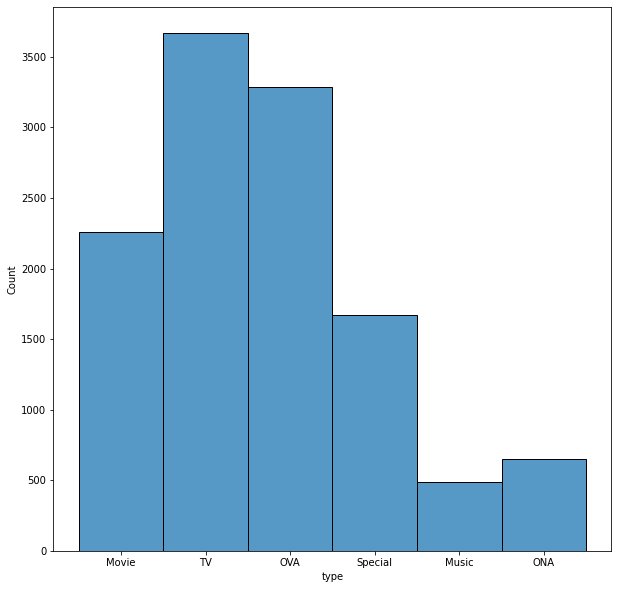

In [ ]:
#เเสดงจำนวนของtype
plt.figure(figsize=(10,10))
sns.histplot(df, x='type');


* จะเห็นได้ว่า type TV มากที่สุด รองลงมาคือ OVA ต่ำที่เป็นคือ Music

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



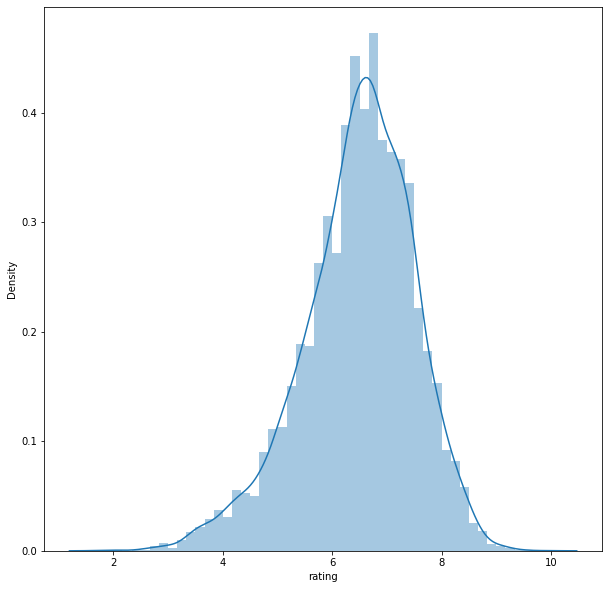

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(df['rating']);

* ช่วงเรทที่เยอะที่สุดจะอยู่ระหว่าง 6-8 คะแนน
* เรทที่น้อยที่สุดจะอยู่ระหว่าง  0-3 และ 9-10 คะแนน

#Feature Engineering

ตรง Feature Engineering ได้ใช้ algorithm ที่เป็น TfidfVectorizer เป็นalgorithmที่ถูกออกแบบมาเพื่อให้ใช้งานได้ง่ายกับข้อความภาษาอังกฤษ

In [ ]:
#Remove all english stop words such as 'the', 'a'
#vocabulary
tf_idf = TfidfVectorizer(lowercase=True, stop_words = 'english')
##Construct the required TF-IDF matrix by fitting and transforming the data/คำนวณให้เป็นvector
tf_idf_matrix = tf_idf.fit_transform(ndf['genre'])
tf_idf_matrix.shape
# จะเห็นว่ามี 46 different genre จาก 12,017 anime

(12017, 43)

In [ ]:
#all vocabulary of tf_idf
space = tf_idf.vocabulary_
print(space)

{'drama': 6, 'romance': 25, 'school': 27, 'supernatural': 37, 'action': 0, 'adventure': 1, 'fantasy': 8, 'magic': 16, 'military': 19, 'shounen': 32, 'comedy': 3, 'historical': 12, 'parody': 22, 'samurai': 26, 'scifi': 28, 'thriller': 39, 'sports': 36, 'superpower': 38, 'space': 35, 'sliceoflife': 34, 'mecha': 18, 'music': 20, 'mystery': 21, 'seinen': 29, 'martialarts': 17, 'vampire': 40, 'shoujo': 30, 'horror': 13, 'police': 23, 'psychological': 24, 'demons': 5, 'ecchi': 7, 'josei': 14, 'shounenai': 33, 'game': 9, 'dementia': 4, 'harem': 10, 'cars': 2, 'kids': 15, 'shoujoai': 31, 'hentai': 11, 'yaoi': 41, 'yuri': 42}


matrix ที่ได้จาก algorithm TfidfVectorizer 

In [ ]:
#โดยจะคำนวณความถี่ของคำโดยพิจารณาจากความถี่ที่ปรากฏใน เรื่องทั้งหมด/เอกสารทั้งหมด
pd.DataFrame(tf_idf_matrix.toarray(),columns=tf_idf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,action,adventure,cars,comedy,dementia,demons,drama,ecchi,fantasy,game,harem,hentai,historical,horror,josei,kids,magic,martialarts,mecha,military,music,mystery,parody,police,psychological,romance,samurai,school,scifi,seinen,shoujo,shoujoai,shounen,shounenai,sliceoflife,space,sports,supernatural,superpower,thriller,vampire,yaoi,yuri
0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.439008,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.488921,0.000000,0.520275,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.545474,0.0,0.00000,0.0,0.0,0.0
1,0.294537,0.315806,0.0,0.000000,0.0,0.0,0.334685,0.0,0.31968,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.450742,0.0,0.0,0.520478,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.353890,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
2,0.262021,0.000000,0.0,0.208687,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.393979,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.466381,0.0,0.0,0.000000,0.573718,0.000000,0.294616,0.0,0.0,0.0,0.314821,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.423940,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.90569,0.0,0.0,0.0
4,0.262021,0.000000,0.0,0.208687,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.393979,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.466381,0.0,0.0,0.000000,0.573718,0.000000,0.294616,0.0,0.0,0.0,0.314821,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12012,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
12013,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
12014,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
12015,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0


#Modeling

##Benchmark


เราได้ทดสอบมา 2 Algorithm คือ TfidfVectorizer และ CountVectorizer

###TfidfVectorizer or CountVectorizer

เลือก TfidfVectorizer เพราะ เป็นการเเบ่งคำเเล้วเอาคำนั้นไป weight ทุกๆ document ที่มีอยู่ ขณะที่ CountVectorizer count แค่คำของrecordนั้นๆ

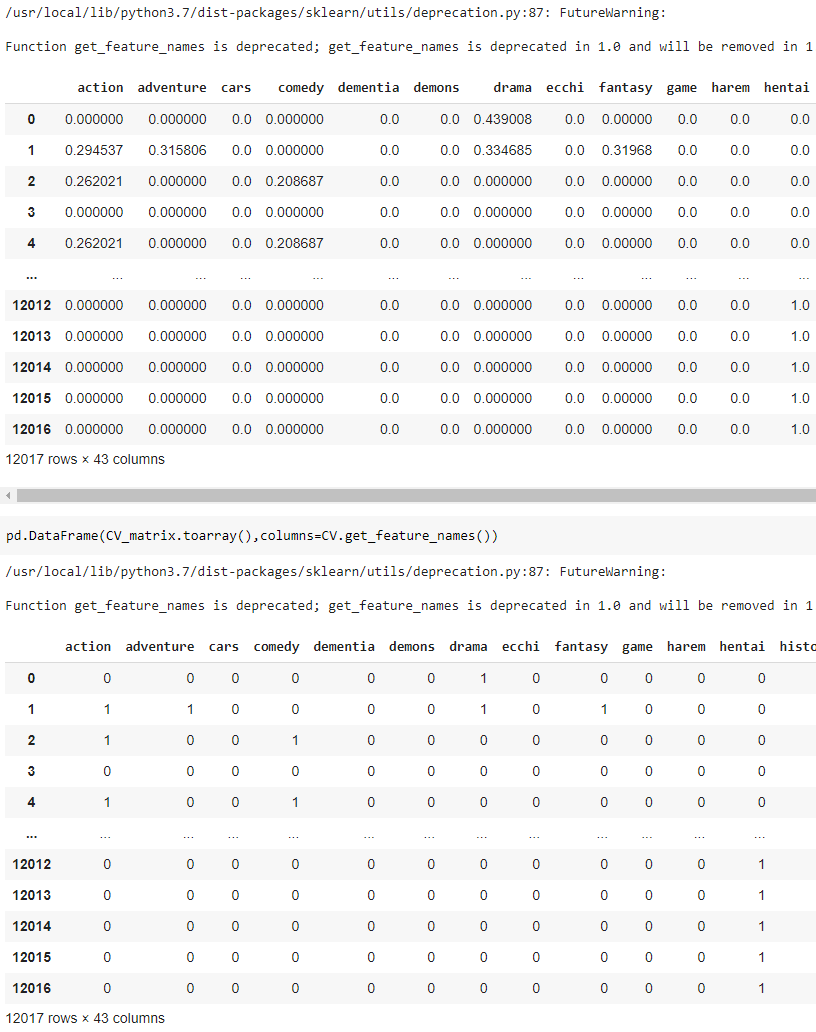

จากการใช้keyword Sword Art Online กับ TfidfVectorizer และ CountVectorizer ที่ใช้ Cosine similarity Model ทั้งคู่
จะเห็นว่ามีการ return อันดับ 1-4 เหมือนกัน แต่ 5-10 ไม่เหมือนกัน อย่างเช่น genre pokemon generations อยู่ในประเภท Kid ซึ่งไม่ครอบคลุมในภาพรวม และค่อนข้างไม่ตรงกับประเภทของ Sword Art Online

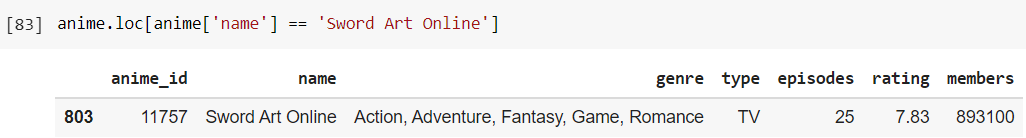

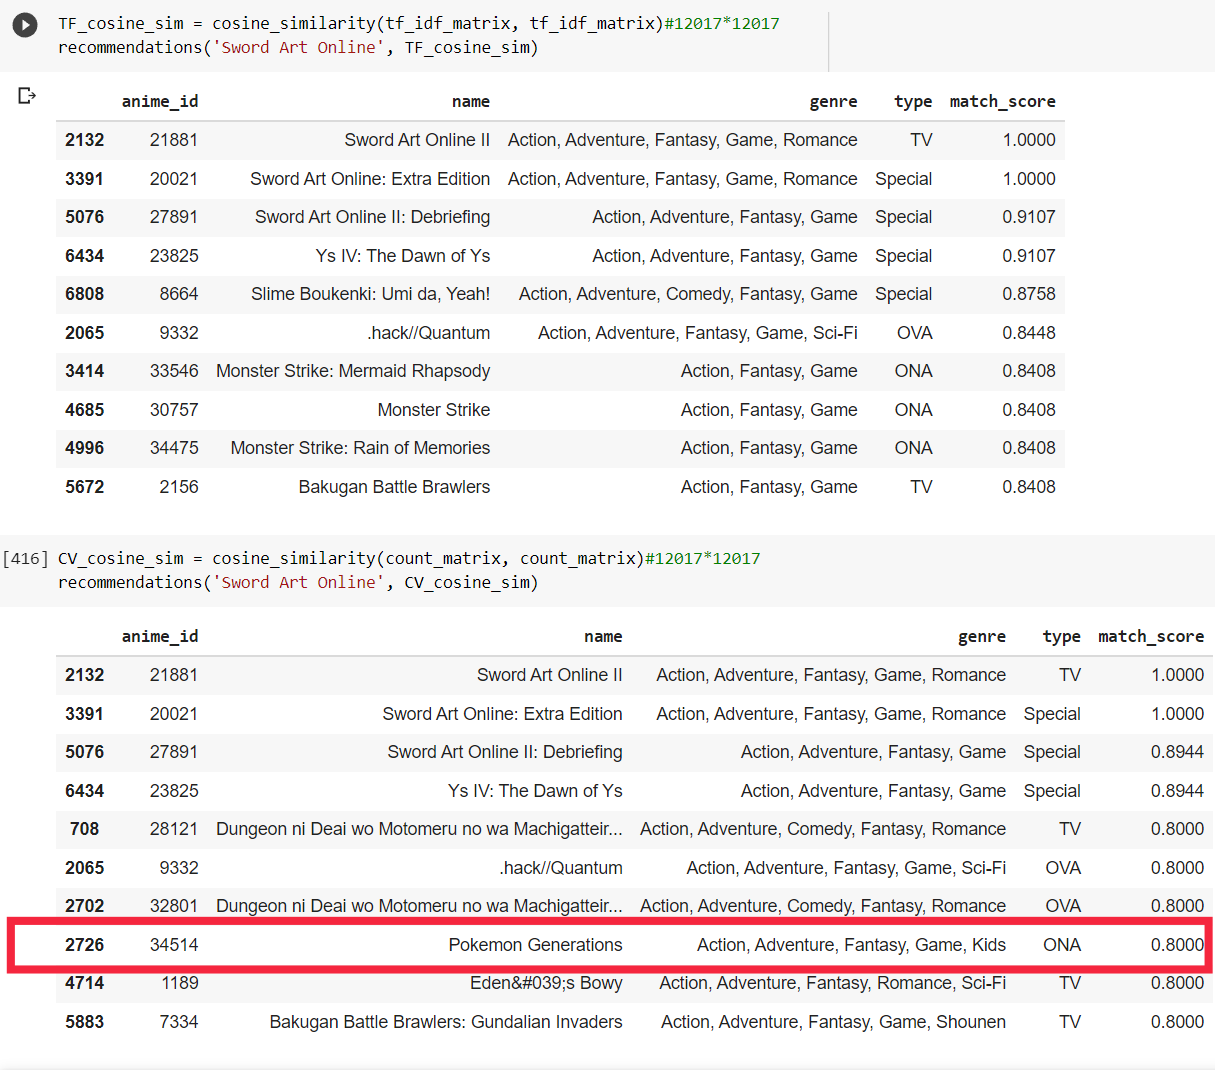

หลังจากเลือก Algorithm TfidfVectorizer ได้แล้ว ซึ่งAlgorithmนี้ใช้ได้ทั้ง Linear kernel  Model และ Cosine similarity Model

###Linear kernel or Cosine similarity

ข้อมูลด้านบนใช้ Tfidf กับ Linear kernel   ด้านล่างใช้ Tfidf กับ Cosine similarity ผลลัพธ์ทั้ง 2 Model return ออกมาเหมือนกัน

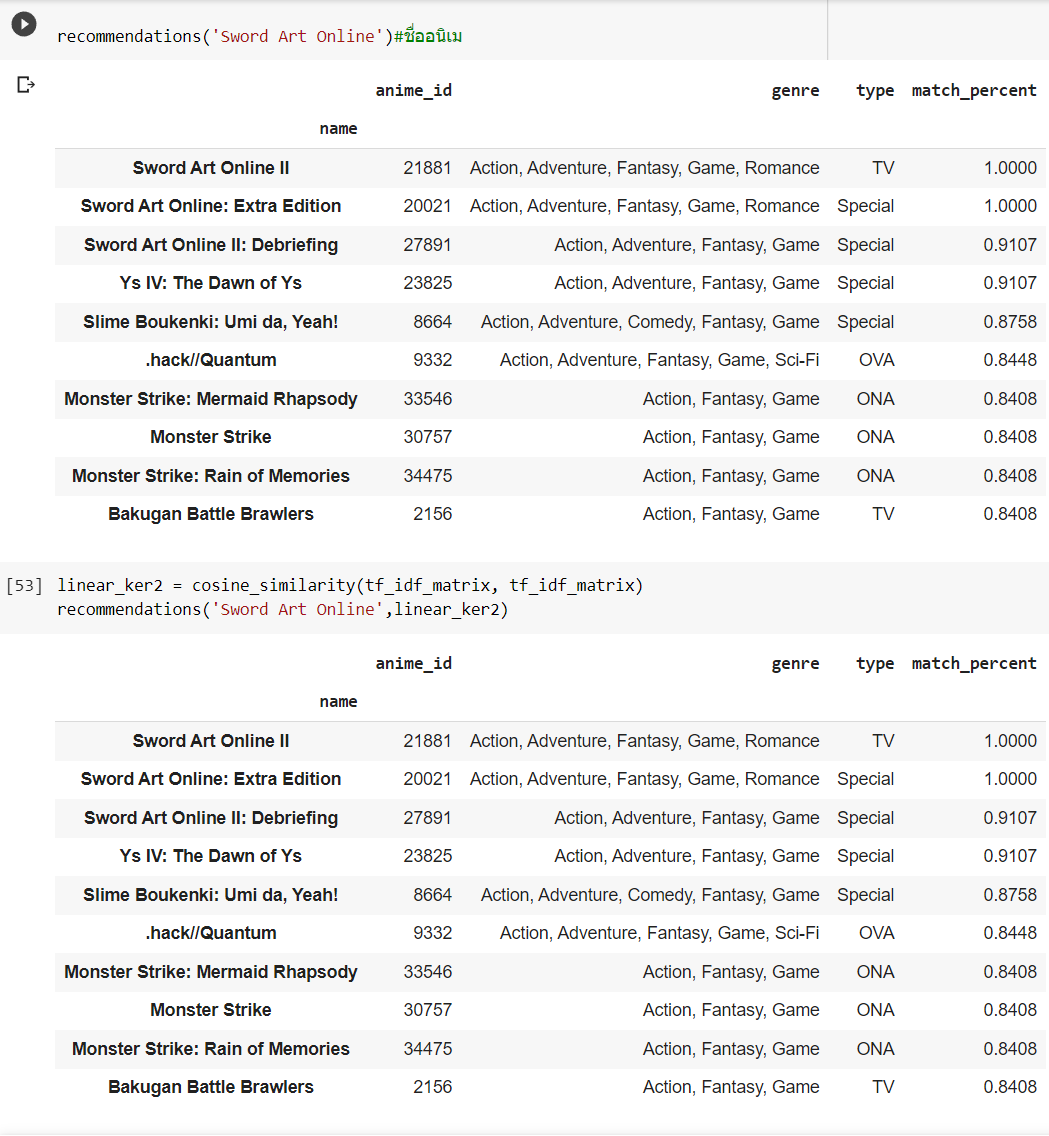

จึงเทียบโมเดลในด้านการใช้เวลาในการคำนวน

###Time

เมื่อLog Timeออกมาจะเห็นว่า 
* Linear kernel Model     ใช้เวลา 1.55 s
* Cosine similarity Model ใช้เวลา 1.62 s

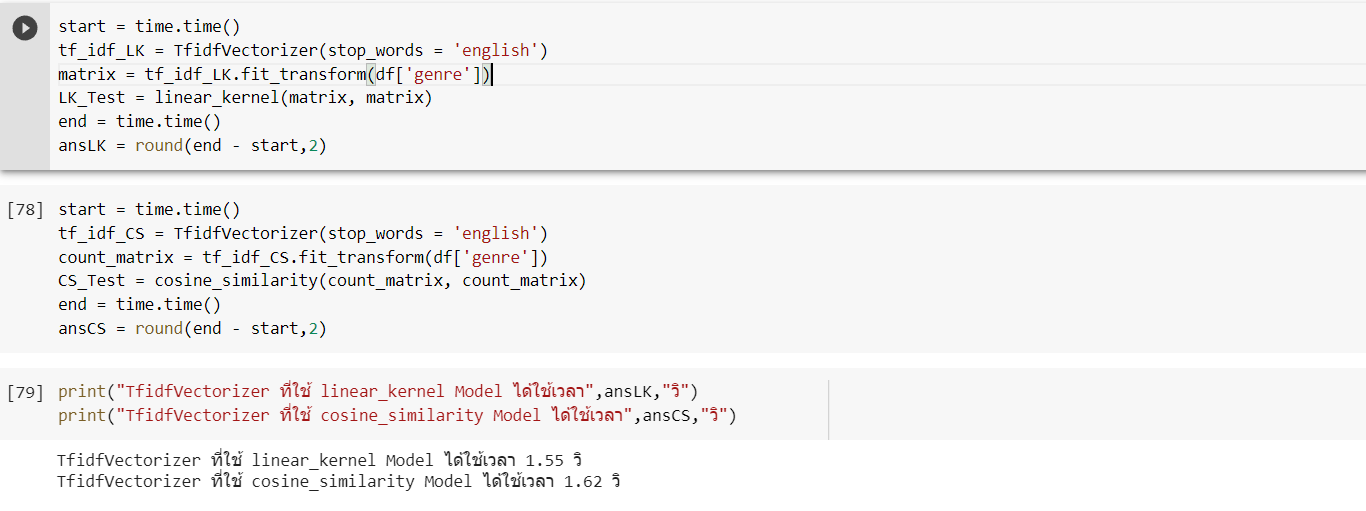

###สรุป ใช้ TfidfVectorizer กับ Linear kernel Model 
เพราะ Tfidf ครอบคลุมที่สุด และ Linear kernel เร็วที่สุด

# Pipeline

Pre-processing
*   drop row where is null
*   Reset index
*   เปลี่ยนหน้าตาgenreให้ใช้กับmodelได้

Feature Engineering
*   TfidfVectorizer

In [ ]:
class PipeLine():
    def __init__(self):
        """
        Pipeline parameters:
            | mapping:เปลี่ยนข้อมูลของgenreเพื่อเอาไปใช้ในModel
        """
        self.mapping = {'Sci-Fi':'SciFi','Slice of Life':'SliceOfLife','Martial Arts':'MartialArts','Super Power':'SuperPower','Shounen Ai':'ShounenAi','Shoujo Ai':'ShoujoAi'}

#drop row ที่มีค่าnull
    def dropRows(self, data):
        data.dropna(axis=0 ,inplace=True)
        return data
#reset index ที่ไม่ถูกต้องของdataframe df
    def reset_index(self,data):
        data.reset_index(drop=True,inplace=True)
        return data

#เปลี่ยนgenreให้ใช้กับmodelได้
    def genre_correction(self, data):
        data['genre'] = data['genre'].replace(self.mapping,regex=True)#เปลี่ยนหน้าตาgenreของทีละเรื่องให้ใช้กับmodelได้
        return data

#Feature Engineering
    def Tf_idf(self,data):
        tf_idf = TfidfVectorizer(lowercase=True, stop_words = 'english')#Remove all english stop words such as 'the', 'a'
        tf_idf_matrix = tf_idf.fit_transform(data['genre'])#Construct the required TF-IDF matrix by fitting and transforming the data/คำนวณให้เป็นmatrix
        return tf_idf_matrix

# execute
    def execution(self,data):
        df = data.copy()
        df = self.dropRows(df)
        df = self.reset_index(df)
        df = self.genre_correction(df)
        return self.Tf_idf(df)



เรียกfunction pipelineเพื่อได้resultออกมาที่ใช้กับ Linear kernel model

In [ ]:
#เรียกpipeline
pipe = PipeLine()

In [ ]:
#ได้resultออกมาจากpipeline
tf_idf_matrix = pipe.execution(anime)

In [ ]:
# Compute the cosine similarity matrix/คำนวณcosine similarity matrix
#each movie overview cosine similarity score with every other movie overview/เเต่ละanimeจะมีคะเเนนความคล้ายคลึงกับเเต่ละanime
linear_ker = linear_kernel(tf_idf_matrix, tf_idf_matrix)#12017*12017
#ดังนั้น animeแต่ละเรื่องจะเป็นเวกเตอร์column 1x12017 โดยที่แต่ละcolumnจะมีคะแนนความคล้ายคลึงกันกับanimeแต่ละเรื่อง

#Deployment


functionที่เอาไปเเสดงในapp

In [ ]:
def recommendations(name, linear_ker = linear_ker):
    indices = pd.Series(df.index, index = df['name'])#เก็บSeries ที่มีทั้งชื่อเรื่องเเละindexของชื่อเรื่อง
    similarity_scores = list(enumerate(linear_ker[indices[name]])) #เอาคะเเนนความคล้ายคลึงของทุกเรื่องที่เกี่ยวกับชื่อนี้ออกมาจากcosine_sim
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True) #เอาindex เเละ คะเเนนความคล้ายคลึงที่เรียงลำดับ ของเรื่องanimeอื่นออกมา
    similarity_scores = similarity_scores[:11]#เลือกว่าจะเอากี่เรื่อง
    anime_indices = [i[0] for i in similarity_scores] #เอาเเต่indexมา
    a = df[['anime_id','name','genre','type']].iloc[anime_indices]#ใช้indexในการดึงข้อมูลของanimeอื่นออกมา เเยกdatafarmeที่มีเเค่column 'anime_id','name','genre','type'
    b = a.loc[a['name'] == name]#เอาข้อมูลที่userเลือกเก็บไว้เเสดงในapp
    a['match_score'] = [i[1] for i in similarity_scores]#column match score
    a['match_score'] = a['match_score'].apply(lambda x: round(x,4)) #apply(lambda x: str(round(x*100 ,2)) + "%")
    a.drop(labels=indices[name],axis=0,inplace=True)#drop row ที่ เป้น name ที่ user search ใน functionนี้
    #a.set_index('name',inplace=True)#column nameขึ้นต้นก่อน
    return b,a

In [ ]:
!pip install gradio -q

     |████████████████████████████████| 979 kB 30.4 MB/s 
     |████████████████████████████████| 1.9 MB 42.5 MB/s 
     |████████████████████████████████| 206 kB 53.2 MB/s 
     |████████████████████████████████| 3.6 MB 39.7 MB/s 
     |████████████████████████████████| 961 kB 43.6 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


In [ ]:
import gradio as gr

ใส่ชื่อAnime เข้าไป 
App จะReturn Anime 10 เรื่อง ที่มีความใกล้เคียงกันออกมา

In [ ]:
iface = gr.Interface(recommendations,inputs=[gr.inputs.Textbox(label='ANIME NAME', default="Aura: Maryuuin Kouga Saigo no Tatakai")],outputs=[gr.outputs.Dataframe(label='YOUR ANIME'),gr.outputs.Dataframe(label='SIMILAR ANIME')])
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://39032.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://39032.gradio.app')

#Reference
https://www.zhihu.com/question/19746144
https://www.datacamp.com/community/tutorials/recommender-systems-python

https://www.kaggle.com/lavanyaanandm/recommending-anime-s-using-all-recommendation-sys#10.-Reference-